# 第2回 機械学習勉強会
## 学習済みモデルの話
### 学習済みモデルをまとめているところ
- [tfhub](https://tfhub.dev/)
  Googleのやつ。
  使い方は書いてあるけど、説明がイマイチわかりにくい。
  こんな感じで簡単に使えるらしい。
  ![usage](img/tfhub_usage.png)
  
- [Model Asset eXchange (IBM)](https://developer.ibm.com/exchanges/models/)

  
## tfhubを使ってみる
### とりあえずインストール
- [installation](https://www.tensorflow.org/hub/installation)

### まあやってみよう
- 以下のテキスト分類器を

[How to build a simple text classifier with TF-Hub](https://www.tensorflow.org/hub/tutorials/text_classification_with_tf_hub)

### 必要ライブラリのimport

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

### データセットの読み込み
- ロードしたデータセット: [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/)
  - 中身は[IMDb](https://www.imdb.com/)という、Amazon.comの運営するTVや映画に対するレビューサイトのレビューをpos, negでラベル付けしたデータ。
  - 50,000のデータの25,000を訓練用、残りを試験用にしている
- file名がid_rating(星の数).txtになっていて、ratingが7以上ならpos, 4以下ならposとしていて、それをsentimentとしてプログラム上表現。
  - テストデータには5以上だったり、5以下のデータセットも含んでいる
- レビューがポジティブならpolarityは1, negativeならpolarityは0になる


In [3]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
  return train_df, test_df

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

train_df, test_df = download_and_load_datasets()
train_df.head()

84131840/84125825 [==============================] - 13s 0us/step


,sentence,sentiment,polarity
0,"Well , I come from Bulgaria where it 's almost...",10,1
1,My short comment for this flick is go pick it ...,8,1
2,"Written by Stephen King, but this treatment is...",4,0
3,This particular Joe McDoakes short subject was...,7,1
4,...though for a film that seems to be trying t...,1,0


### Estimatorを使うための準備
- まずモデルを試すためのEstimatorを準備するために、入力データセットを作る
- 追加学習用、学習用データセットからのテスト用、予測用データセットからのテスト用

In [5]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], num_epochs=None, shuffle=True)

# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], shuffle=False)
# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    test_df, test_df["polarity"], shuffle=False)

### tfhubからモデルを読み込み
ここでようやくnnlm-en-dim128というモデルを読み込んでいる模様
keyはInput側のどの要素を使うかの指定。ここではsentenceなところを入力値に使うとしている

In [6]:
embedded_text_feature_column = hub.text_embedding_column(
    key="sentence", 
    module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")

### TFHubからもってくる
- DNN(Deep Neural Networking)分類器を使う

In [7]:
estimator = tf.estimator.DNNClassifier(
    hidden_units=[500, 100],
    feature_columns=[embedded_text_feature_column],
    n_classes=2,
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

### 学習

In [ ]:
estimator.train(input_fn=train_input_fn, steps=1000);

### 評価

In [13]:
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

print("Training set accuracy: {accuracy}".format(**train_eval_result))
print("Test set accuracy: {accuracy}".format(**test_eval_result))

Training set accuracy: 0.8031600117683411
Test set accuracy: 0.7934799790382385


### 自分で適当なデータを作って試してみる

In [32]:
text = ["Yeah!! this is a great!! I am a fun of this movie.", "Wow... this is a terrible. I will not watch this movie again."]

predict_df = pd.DataFrame({ 'sentence' : text, 'polarity': [8,3]})
predict_fn = tf.estimator.inputs.pandas_input_fn(
    predict_df, predict_df["polarity"], num_epochs=1, shuffle=True)
predictions = estimator.predict(input_fn=predict_fn)

    print(i)
    print("{} =>  neg: {} / pos: {}".format(text[i], p["probabilities"][0], p["probabilities"][1]))

0
Yeah!! this is a great!! I am a fun of this movie. =>  neg: 0.11237171292304993 / pos: 0.8876282572746277
1
Wow... this is a terrible. I will not watch this movie again. =>  neg: 0.6576606035232544 / pos: 0.34233948588371277


### ConfusionMatrix(偽陰性、偽陽性を見るやつ)

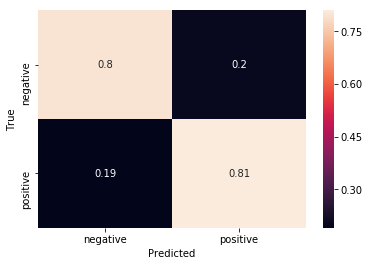

In [10]:
def get_predictions(estimator, input_fn):
  return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    "negative", "positive"
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
  cm = tf.confusion_matrix(train_df["polarity"], 
                           get_predictions(estimator, predict_train_input_fn))
  with tf.Session() as session:
    cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");